In [1]:
from pyspark.sql import SQLContext
from pyspark.sql import DataFrameNaFunctions
import pandas as pd
from pyspark.mllib.linalg import DenseVector
from numpy import array
from math import sqrt
from pyspark.ml.clustering import KMeans
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
sqlContext = SQLContext(sc)

In [3]:
dataDF = sqlContext.read.load('file:///home/cloudera/coursera/courseraDataSimulation/course4-ML/minute_weather.csv', 
                          format='com.databricks.spark.csv', 
                          header='true',inferSchema='true')

In [4]:
dataDF.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
rowID,1587257,793628.0,458201.7724491035,0,1587256
air_pressure,1587257,916.8301266904964,3.051593126680745,905.0,929.5
air_temp,1587257,61.85144042834878,11.833623786835721,31.64,99.5
avg_wind_direction,1586824,161.96537927331576,95.20811970203971,0.0,359.0
avg_wind_speed,1586824,2.774272067979844,2.0607577935630355,0.0,32.3
max_wind_direction,1586824,163.40304784903682,92.3672342806429,0.0,359.0
max_wind_speed,1586824,3.3998134008569685,2.423167433617133,0.1,36.0
min_wind_direction,1586824,166.82637078844283,97.46274620077615,0.0,359.0
min_wind_speed,1586824,2.1331304542917913,1.745345084932679,0.0,32.0


In [5]:
dataDF.count()

1587257

In [6]:
#Re-sample to take every 10th value and count new dataset

filtered = dataDF.filter((dataDF.rowID % 10) == 0)
T=filtered.count()
T

158726

In [7]:
# Review the number of zeros in rain_accumulation column
R1 = filtered.filter(filtered.rain_accumulation < 0.0001).count() 

# Count the number of zeros in rain_duration column
R2 = filtered.filter(filtered.rain_duration < 0.0001).count() 

# We can drop these two columns since most values are ZERO
print "Zeros in rain_accumulation = {} and in rain_duration = {} out of {}".format(R1, R2, T)

Zeros in rain_accumulation = 13134 and in rain_duration = 12839 out of 158726


In [8]:
#SELECT required columns 

cols = [
 'air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction', 'max_wind_speed',
 'relative_humidity']

In [9]:
# Select the required columns of interest and count how many rows:
workingDF = filtered.select(cols)
initial = workingDF.count()

In [10]:
# Drop rows with missing values and count how many rows we dropped

workingDF = workingDF.na.drop()
remaining = workingDF.count()
initial - remaining

46

In [11]:
workingDF.take(2)

[Row(air_pressure=912.3, air_temp=64.76, avg_wind_direction=97.0, avg_wind_speed=1.2, max_wind_direction=106.0, max_wind_speed=1.6, relative_humidity=60.5),
 Row(air_pressure=912.3, air_temp=62.24, avg_wind_direction=144.0, avg_wind_speed=1.2, max_wind_direction=167.0, max_wind_speed=1.8, relative_humidity=38.5)]

In [12]:
# CONVERT SPEED from meters/sec to miles per hour
workingDF = workingDF.withColumn('avg_wind_speed', workingDF.avg_wind_speed * 2.236)
workingDF = workingDF.withColumn('max_wind_speed', workingDF.max_wind_speed * 2.236)

In [13]:
# REVIEW the columns we have in workingDF.columns

In [14]:
# ASSEMBLE all the features.

from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=cols, outputCol="features_pre")
assembled = assembler.transform(workingDF)

In [15]:
# SCALE the dataset.

from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="features_pre", outputCol="features",withStd=True, withMean=True)
# Fit the StandardScaler
scalerModel = scaler.fit(assembled)
# Normalize each feature
scaledData = scalerModel.transform(assembled)

## Compare Statistics of Scaled Data vs Original Data

In [16]:
# UNSCALED : Extract "features_pre" and describe "features_pre"

splitVector = lambda x: pd.Series([i for i in x])

N = scaledData.select("features_pre").toPandas()
unScaledDF = N['features_pre'].apply(splitVector)
unScaledDF.describe(percentiles=[])

,0,1,2,3,4,5,6
count,158680.000000,158680.000000,158680.000000,158680.000000,158680.000000,158680.000000,158680.000000
mean,916.830407,61.855783,162.156100,6.205381,163.462144,7.603647,47.596920
std,3.051687,11.832516,95.278201,4.600847,92.452139,5.408440,26.207831
min,905.000000,31.640000,0.000000,0.000000,0.000000,0.223600,0.900000
50%,916.700000,62.420000,182.000000,4.919200,187.000000,6.037200,44.700000
max,929.500000,99.500000,359.000000,71.328400,359.000000,80.496000,93.000000


In [17]:
# SCALED : Extract "features" and describe "features"

T = scaledData.select("features").toPandas()
scaledDF = T['features'].apply(splitVector)
scaledDF.describe(percentiles=[])

,0,1,2,3,4,5,6
count,1.586800e+05,1.586800e+05,1.586800e+05,1.586800e+05,1.586800e+05,1.586800e+05,1.586800e+05
mean,8.484653e-13,-2.153480e-14,-6.960874e-15,1.636591e-15,-4.257592e-15,-4.196787e-16,5.824565e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.876677e+00,-2.553623e+00,-1.701922e+00,-1.348747e+00,-1.768073e+00,-1.364543e+00,-1.781793e+00
50%,-4.273279e-02,4.768364e-02,2.082732e-01,-2.795530e-01,2.545950e-01,-2.896301e-01,-1.105364e-01
max,4.151668e+00,3.181421e+00,2.065991e+00,1.415457e+01,2.115017e+00,1.347752e+01,1.732424e+00


In [18]:
# Keep features and leave other columns

scaledData = scaledData.select("features")
scaledData.persist()

DataFrame[features: vector]

In [19]:
# Let us write a function that evaluates the Errors: WSSE  -  Within Set Sum of Squared Errors.

def computeCost(featuresAndPrediction, model):
    # Get centers of all clusters
    allClusterCenters = [DenseVector(c) for c in model.clusterCenters()]
    # Map to a collection of arrays
    arrayCollection   = featuresAndPrediction.rdd.map(array)
    # Given a point, return its distance from Center of the Class assigned

    def error(point, predictedCluster):
        center = allClusterCenters[predictedCluster]
        z      = point - center
        return sqrt((z*z).sum())
    
    return arrayCollection.map(lambda row: error(row[0], row[1])).reduce(lambda x, y: x + y)

In [20]:
#ELBOW method

wssseList = []

for howManyClusters in range(2,31):
    #train kmeans
    print "Training for k = {} ".format(howManyClusters)
    kmeans      = KMeans(k=howManyClusters, seed = 1)
    %time model       = kmeans.fit(scaledData)
    %time transformed = model.transform(scaledData)
    featuresAndPrediction     = transformed.select("features", "prediction")
    
    #get wsse
    %time W = computeCost(featuresAndPrediction, model)
    print "WSSSE = {} ".format(W)
    
    #store wsse so we can plot it
    wssseList.append(W)

Training for k = 2 
CPU times: user 13 ms, sys: 14 ms, total: 27 ms
Wall time: 19.7 s
CPU times: user 0 ns, sys: 2 ms, total: 2 ms
Wall time: 130 ms
CPU times: user 11 ms, sys: 20 ms, total: 31 ms
Wall time: 18.7 s
WSSSE = 348521.951115 
Training for k = 3 
CPU times: user 0 ns, sys: 12 ms, total: 12 ms
Wall time: 6.82 s
CPU times: user 1 ms, sys: 0 ns, total: 1 ms
Wall time: 122 ms
CPU times: user 10 ms, sys: 26 ms, total: 36 ms
Wall time: 14.7 s
WSSSE = 307527.01438 
Training for k = 4 
CPU times: user 2 ms, sys: 9 ms, total: 11 ms
Wall time: 8.88 s
CPU times: user 2 ms, sys: 0 ns, total: 2 ms
Wall time: 99.9 ms
CPU times: user 10 ms, sys: 12 ms, total: 22 ms
Wall time: 15.6 s
WSSSE = 283783.638931 
Training for k = 5 
CPU times: user 2 ms, sys: 17 ms, total: 19 ms
Wall time: 4.98 s
CPU times: user 1 ms, sys: 999 µs, total: 2 ms
Wall time: 151 ms
CPU times: user 8 ms, sys: 20 ms, total: 28 ms
Wall time: 14.1 s
WSSSE = 264162.225034 
Training for k = 6 
CPU times: user 2 ms, sys: 10 m

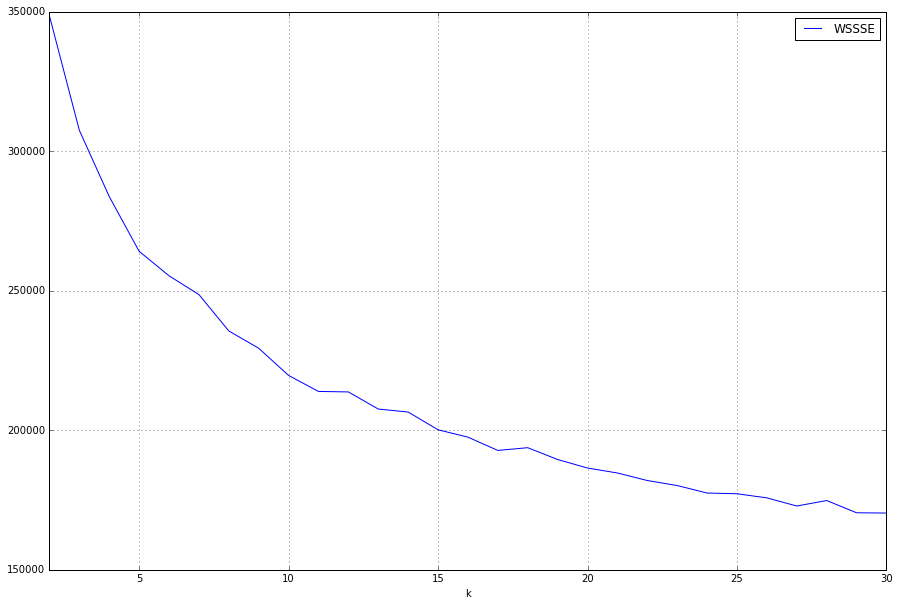

In [21]:
wssseDF = pd.DataFrame({'WSSSE' : wssseList, 'k' : range(2,31) })
wssseDF.plot(y='WSSSE', x='k', figsize=(15,10), grid=True)

# Clustering on entire dataset

In [22]:
# Once ELBOW is performed on re-sampled dataset, let us run k-means on FULL data set

#Get Full Dataset
full 	= dataDF
#How big is this dataset ?
full.count()

1587257

In [23]:
#Select required columns and Drop rows with missing fields
fullDF 	= full.select(cols).na.drop()
#Clear some memory
del full
#How many rows remain ?
fullDF.count()

1586824

In [24]:
#CONVERT Speed from meters/sec to miles per hour
fullDF 	= fullDF.withColumn('avg_wind_speed', fullDF.avg_wind_speed * 2.236)
fullDF 	= fullDF.withColumn('max_wind_speed', fullDF.max_wind_speed * 2.236)

#ASSEMBLE all the features into one column
fullAssembled 	= assembler.transform(fullDF)

#SCALE the dataset column 'features'.
scalerFullModel	= scaler.fit(fullAssembled)
scaledFullData 	= scalerFullModel.transform(fullAssembled)

#SELECT the features column and persist the dataframe
scaledFullData 	= scaledFullData.select("features")
scaledFullData.persist()

DataFrame[features: vector]

In [25]:
# Re-Sampled dataset: Review the graph above and run k-means for a specific k on smaller dataset:
kmeans			= KMeans(k=11, seed = 1)
model			= kmeans.fit(scaledData)
transformed		= model.transform(scaledData)
featuresAndPrediction	= transformed.select("features", "prediction")
errorWSSSE		= computeCost(featuresAndPrediction, model)
print(errorWSSSE)

213931.099861


In [26]:
#How many members per clusters
import pyspark.sql.functions as func

featuresAndPrediction.groupby(featuresAndPrediction.prediction).agg(func.count('prediction')).show()

+----------+-----------------+
|prediction|count(prediction)|
+----------+-----------------+
|         0|            11130|
|         1|             6618|
|         2|            19000|
|         3|            12929|
|         4|            15766|
|         5|            15628|
|         6|            20160|
|         7|            23787|
|         8|            13917|
|         9|             8204|
|        10|            11541|
+----------+-----------------+



In [27]:
from pandas.tools.plotting import parallel_coordinates
import numpy as np

In [28]:
colNames = ['air_pressure','air_temp','avg_wind_direction','avg_wind_speed',
'max_wind_direction','max_wind_speed','relative_humidity', 'prediction']

In [29]:
# Get the cluster centers
C = model.clusterCenters()

# Zip with a column called 'prediction' (index)
Z = [np.append(A, index) for index, A in enumerate(C)]

# Convert to pandas for plotting
P = pd.DataFrame(Z, columns=colNames)
P['prediction'] = P['prediction'].astype(int)

In [30]:
P

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity,prediction
0,-1.143608,-0.882498,0.442351,1.938530,0.535035,1.897942,0.921724,0
1,0.235574,0.320827,1.887717,-0.652202,-1.551193,-0.577112,-0.284171,1
2,-0.237797,0.856418,-1.301769,-0.580907,-1.161884,-0.598166,-0.586259,2
3,0.286854,0.783609,1.330664,-0.632344,1.594514,-0.582801,-0.748623,3
4,-0.896779,-1.143427,0.366916,0.238478,0.468811,0.227791,1.342106,4
5,0.344960,-0.964678,0.662956,-0.534096,0.856779,-0.516286,1.086785,5
6,-0.177939,0.610278,0.406468,0.666915,0.515692,0.608831,-0.177008,6
7,-0.222971,0.600411,0.199593,-0.630223,0.375516,-0.643902,-0.398810,7
8,1.342904,-0.046006,-1.139442,-0.173248,-0.996086,-0.156849,-0.976423,8
9,1.197331,-0.249639,-1.154034,2.046549,-1.051449,2.160925,-1.129526,9


## Plots

## Dry Days

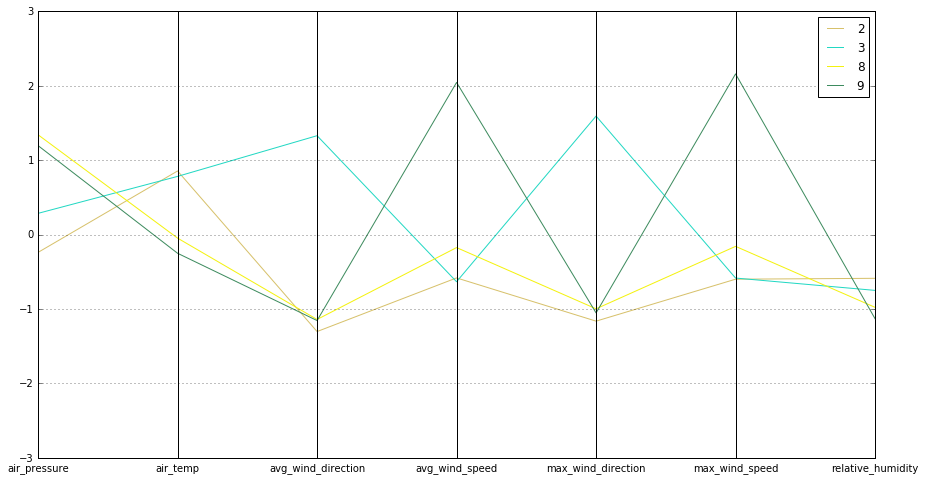

In [31]:
# Parallel Coordinates Plot 1: Dry Days (Low Humidity)
plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
parallel_coordinates(P[P['relative_humidity']< -0.5], 'prediction')

## Warm Days

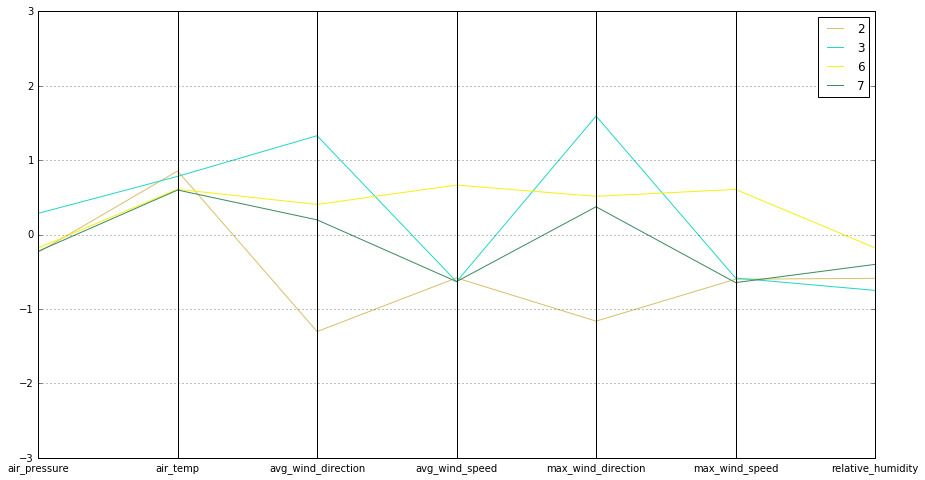

In [32]:
# Parallel Coordinates Plot 1: Warm Days (High Temperature)
plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
parallel_coordinates(P[P['air_temp']> 0.5], 'prediction')

## Cool Days

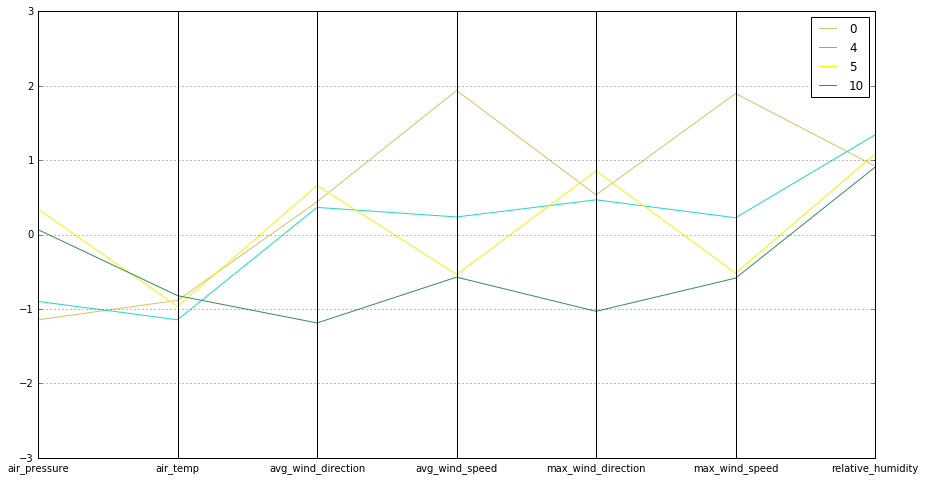

In [33]:
# Parallel Coordinates Plot 1: Cool and Possibily Rainy Days (High Humidity, Low Temp)
plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
parallel_coordinates(P[(P['relative_humidity']>0.5) & (P['air_temp']< 0.5)], 'prediction')

## Other Days

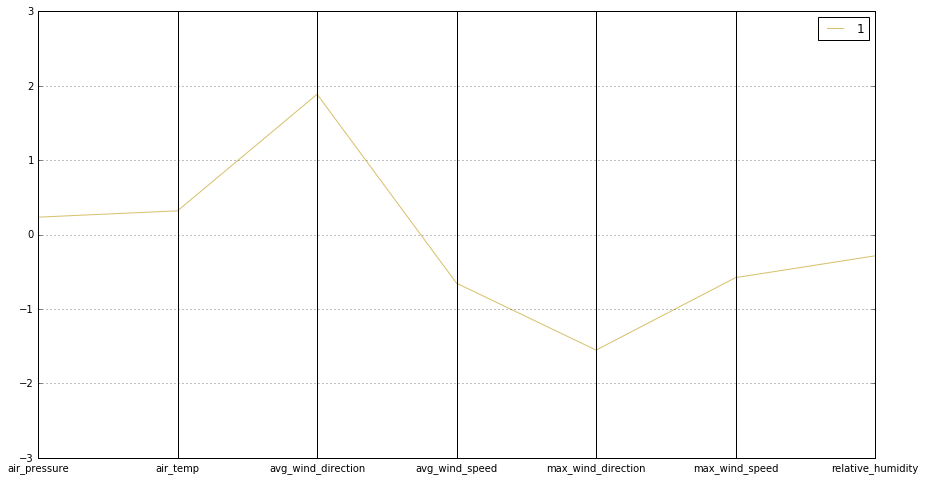

In [35]:
# Parallel Coordinates Plot 1: Dry Days (Low Humidity)
plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])

parallel_coordinates(P.iloc[[1]], 'prediction')